In [1]:
import numpy as np
import argparse
import os
import sys
import random
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
import mask_backward_v4
import matplotlib.pyplot as plt
# from mask_backward_v1 import mask_backward, mask_eval
# from mask_backward_v2 import mask_backward, mask_eval
from mask_backward_v4 import mask_backward, mask_eval
from utils import *
from mnet import MNet
sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

#### import data to test mask_backward function

In [2]:
# data_gt = np.load('/home/huangz78/data/data_gt.npz')
datafornn = np.load('/mnt/shared_a/data/fastMRI/knee_singlecoil_train.npz')['data']
# data = np.load('/home/huangz78/data/traindata_x.npz')
dtyp = torch.float
xfull = torch.tensor(datafornn,dtype=dtyp)
# xfull = torch.tensor(data['xfull'],dtype=dtyp)
# fullmask = torch.tensor(data['mask']) # a random mask

##### greedy mask and relevant data

In [ ]:
from sklearn.model_selection import train_test_split

imgs   = torch.tensor( np.load('/home/huangz78/data/data_gt.npz')['imgdata'] ).permute(2,0,1)
masks  = torch.tensor( np.load('/home/huangz78/data/data_gt_greedymask.npz')['mask'].T ) # labels are already rolled
imgNum = imgs.shape[0]
traininds, testinds = train_test_split(np.arange(imgNum),random_state=0,shuffle=True,train_size=round(imgNum*0.8))

In [ ]:
# reload(utils)
# from utils import hfen
reload(mask_backward_v3)
from mask_backward_v3 import mask_backward, mask_eval
# import unet_model
# reload(unet_model)
# from unet_model import UNet

In [ ]:
corefreq = 8
budget = 32
mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(weights_init)
mnet.eval()
### load a unet for maskbackward
# UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
# unetpath = '/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth'
# unetpath = '/home/huangz78/checkpoints/unet_1_False.pth'

unet_skip = True
UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
unetpath = '/home/huangz78/checkpoints/unet_1_'+str(unet_skip)+'.pth'
checkpoint = torch.load(unetpath)
UNET.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from: ' + unetpath )
UNET.train()
print('nn\'s are ready')

In [ ]:
# for (8,32) setting
maxIter_mb = 30
lr_mb      = 1e-2
print('preselect_num = ',corefreq)
print('budget = ',budget)

xstar = xfull[0,:,:].view(-1,320,320)
# xstar    = imgs[testinds[testinds.size//2:],:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

# base_eq = torch.flatten( torch.tensor( [[1,0] for i in range(budget//2)] ) )
# highmask = torch.zeros((320-corefreq))
# highmask[(320-corefreq - budget)//2:(320-corefreq+budget)//2] = base_eq
highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
highmask = highmask.view(-1,320-corefreq)

fullmask = mask_complete(highmask,320,dtyp=torch.float).view(-1)
kplot(fullmask,roll=False,img_name='random mask')

highmask_refined, _, mask_loss, init_mask_loss = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                  beta=1.,alpha=1e-4,c=1e-3,\
                  maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                  lr=lr_mb,mode='UNET',budget=budget,normalize=True,\
                  verbose=True,dtyp=torch.float,testmode='sigpy',hfen=True,return_loss_only=False,\
                  save_cp=False)

fullmask = mask_complete(highmask_refined,320,dtyp=torch.float).view(-1)
kplot(fullmask,roll=False,img_name='refined mask')

In [ ]:
res_path = '/home/huangz78/checkpoints/mb_rec.npz'
res = np.load(res_path)
l2loss   = res['l2loss']
hfen     = res['hfen']
sparsity = res['sparsity']

In [ ]:
# for (24,56) setting
mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
              beta=1.,alpha=10**(-9.5),c=1e-2,\
              maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
              lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
              verbose=True,dtyp=torch.float,testmode='sigpy',hfen=True,return_loss_only=True)

# 8-fold check

In [3]:
corefreq = 8
budget   = 32

mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(weights_init)
mnet.eval()
print('mnet is randomly initialized by PyTorch default setting~')

mnet is randomly initialized by PyTorch default setting~


In [4]:
xstar = xfull[0:5,:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

NN         = 9
# alpha_grid = 10**(np.array([-4,-3.5,-3,-2.5,-2]))
alpha_grid = 10**(np.linspace(-5,-4,NN))
# c_grid     = np.array([1e-4])
c_grid     = np.array([1e-4,1e-3,1e-2])
print('alpha grid: ',alpha_grid)
print('c grid: ',c_grid)
l2loss   = np.zeros((NN,5))
hfen     = np.zeros((NN,5))
sparsity = np.zeros((NN,5))

maxIter_mb = 30
lr_mb      = 1e-2

unet_skip = True # unet n_channels = 1
# unet_skip = False # unet n_channels = 2

alpha grid:  [1.00000000e-05 1.33352143e-05 1.77827941e-05 2.37137371e-05
 3.16227766e-05 4.21696503e-05 5.62341325e-05 7.49894209e-05
 1.00000000e-04]
c grid:  [0.0001 0.001  0.01  ]


In [5]:
lowfreqmask = mask_naiveRand(xstar.shape[1],fix=corefreq,other=0,roll=True)[0]

yfull = torch.fft.fftshift(F.fftn(xstar,dim=(1,2),norm='ortho'),dim=(1,2)) # y is ROLLED!
y = torch.zeros((yfull.shape[0],2,yfull.shape[1],yfull.shape[2]),dtype=torch.float,device='cpu')
y[:,0,lowfreqmask==1,:] = torch.real(yfull)[:,lowfreqmask==1,:]
y[:,1,lowfreqmask==1,:] = torch.imag(yfull)[:,lowfreqmask==1,:]
highmask = mnet(y).detach()
# highmask = torch.sigmoid( mnet(y) ).detach()
# highmask = mask_makebinary(raw_normalize(highmask,budget,threshold=0.5),threshold=0.5,sigma=False)

/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


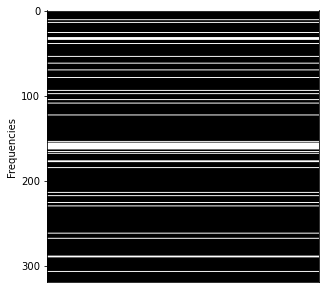

In [6]:
highmask_view = mask_makebinary(raw_normalize(torch.sigmoid(highmask),budget,threshold=0.5),threshold=0.5,sigma=False)
fullmask = mask_complete(highmask_view,320)
kplot(fullmask[0,:])

In [7]:
# highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
# highmask = highmask.repeat(5,1)

c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}')
        # load a unet for maskbackward
#         UNET = UNet(n_channels=2,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
#         unetpath = '/home/huangz78/checkpoints/unet_2_'+str(unet_skip)+'.pt'
        UNET = UNet(n_channels=1,n_classes=1,bilinear=(not unet_skip),skip=unet_skip)
        unetpath = '/home/huangz78/checkpoints/unet_1_'+str(unet_skip)+'.pth'
        checkpoint = torch.load(unetpath)
        UNET.load_state_dict(checkpoint['model_state_dict'])
        print('Unet loaded successfully from: ' + unetpath )
        UNET.train()
        (l2loss[a_ind,c_ind],hfen[a_ind,c_ind]),sparsity[a_ind,c_ind] =\
                        mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode='sigpy',hfen=True,\
                          return_loss_only=True)
        a_ind += 1
    print('\n')
    c_ind += 1

c_ind 1 out of 3
alpha_ind 1 out of 9
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.12889870405197143, 0.8511625051498413)
Iter 1, rows added: 0.0, rows reducted: 32.0, current samp. ratio: 0.025


/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/aten/src/ATen/native/Copy.cpp:240.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


Iter 2, rows added: 15.8, rows reducted: 0.0, current samp. ratio: 0.074375
Iter 3, rows added: 31.4, rows reducted: 2.6, current samp. ratio: 0.164375
Iter 4, rows added: 9.2, rows reducted: 8.4, current samp. ratio: 0.166875
Iter 5, rows added: 27.6, rows reducted: 2.4, current samp. ratio: 0.245625
Iter 6, rows added: 13.8, rows reducted: 14.2, current samp. ratio: 0.244375
Iter 7, rows added: 26.0, rows reducted: 31.6, current samp. ratio: 0.226875
Iter 8, rows added: 15.2, rows reducted: 10.2, current samp. ratio: 0.2425
Iter 9, rows added: 28.6, rows reducted: 32.8, current samp. ratio: 0.229375
Iter 10, rows added: 30.2, rows reducted: 16.0, current samp. ratio: 0.27375
Iter 11, rows added: 44.4, rows reducted: 39.4, current samp. ratio: 0.289375
Iter 12, rows added: 33.6, rows reducted: 24.2, current samp. ratio: 0.31875
Iter 13, rows added: 47.0, rows reducted: 49.8, current samp. ratio: 0.31
Iter 14, rows added: 40.8, rows reducted: 22.8, current samp. ratio: 0.36625
Iter 15,

Iter 9, rows added: 14.2, rows reducted: 9.8, current samp. ratio: 0.1175
Iter 10, rows added: 6.6, rows reducted: 6.6, current samp. ratio: 0.1175
Iter 11, rows added: 15.6, rows reducted: 11.8, current samp. ratio: 0.129375
Iter 12, rows added: 11.0, rows reducted: 9.2, current samp. ratio: 0.135
Iter 13, rows added: 16.8, rows reducted: 13.8, current samp. ratio: 0.144375
Iter 14, rows added: 11.0, rows reducted: 9.6, current samp. ratio: 0.14875
Iter 15, rows added: 15.2, rows reducted: 16.0, current samp. ratio: 0.14625
Iter 16, rows added: 14.4, rows reducted: 7.2, current samp. ratio: 0.16875
Iter 17, rows added: 16.8, rows reducted: 19.6, current samp. ratio: 0.16
Iter 18, rows added: 11.8, rows reducted: 8.4, current samp. ratio: 0.170625
Iter 19, rows added: 20.0, rows reducted: 19.2, current samp. ratio: 0.173125
Iter 20, rows added: 13.6, rows reducted: 11.6, current samp. ratio: 0.179375
Iter 21, rows added: 22.2, rows reducted: 20.8, current samp. ratio: 0.18375
Iter 22, 

Iter 17, rows added: 7.8, rows reducted: 5.0, current samp. ratio: 0.0925
Iter 18, rows added: 4.0, rows reducted: 4.4, current samp. ratio: 0.09125
Iter 19, rows added: 6.2, rows reducted: 7.2, current samp. ratio: 0.088125
Iter 20, rows added: 4.4, rows reducted: 4.2, current samp. ratio: 0.08875
Iter 21, rows added: 8.6, rows reducted: 6.2, current samp. ratio: 0.09625
Iter 22, rows added: 6.4, rows reducted: 3.8, current samp. ratio: 0.104375
Iter 23, rows added: 5.2, rows reducted: 8.0, current samp. ratio: 0.095625
Iter 24, rows added: 7.2, rows reducted: 5.6, current samp. ratio: 0.100625
Iter 25, rows added: 7.2, rows reducted: 9.0, current samp. ratio: 0.095
Iter 26, rows added: 8.0, rows reducted: 5.6, current samp. ratio: 0.1025
Iter 27, rows added: 6.8, rows reducted: 7.2, current samp. ratio: 0.10125
Iter 28, rows added: 6.2, rows reducted: 5.6, current samp. ratio: 0.103125
Iter 29, rows added: 8.8, rows reducted: 5.2, current samp. ratio: 0.114375
Iter 30, rows added: 4.

Iter 25, rows added: 52.6, rows reducted: 57.4, current samp. ratio: 0.411875
Iter 26, rows added: 62.4, rows reducted: 42.4, current samp. ratio: 0.474375
Iter 27, rows added: 53.4, rows reducted: 65.6, current samp. ratio: 0.43625
Iter 28, rows added: 63.4, rows reducted: 48.0, current samp. ratio: 0.484375
Iter 29, rows added: 51.2, rows reducted: 62.6, current samp. ratio: 0.44875
Iter 30, rows added: 61.4, rows reducted: 43.2, current samp. ratio: 0.505625

return at Iter ind:  30
samp. ratio: 0.505625, loss of returned mask: (0.05081274285912514, 0.4286351799964905) 

alpha_ind 2 out of 9
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.12889876067638398, 0.8511631488800049)
Iter 1, rows added: 0.0, rows reducted: 32.0, current samp. ratio: 0.025
Iter 2, rows added: 11.8, rows reducted: 0.0, current samp. ratio: 0.061875
Iter 3, rows added: 21.2, rows reducted: 2.6, current samp. ratio: 0.12
Iter 4, rows added: 5.0, rows reduct

loss of the input mask:  (0.12889866530895233, 0.8511621117591858)
Iter 1, rows added: 0.0, rows reducted: 32.0, current samp. ratio: 0.025
Iter 2, rows added: 7.4, rows reducted: 0.0, current samp. ratio: 0.048125
Iter 3, rows added: 9.6, rows reducted: 0.8, current samp. ratio: 0.075625
Iter 4, rows added: 4.0, rows reducted: 5.8, current samp. ratio: 0.07
Iter 5, rows added: 11.4, rows reducted: 2.2, current samp. ratio: 0.09875
Iter 6, rows added: 5.0, rows reducted: 1.6, current samp. ratio: 0.109375
Iter 7, rows added: 3.2, rows reducted: 11.0, current samp. ratio: 0.085
Iter 8, rows added: 3.2, rows reducted: 2.0, current samp. ratio: 0.08875
Iter 9, rows added: 8.2, rows reducted: 6.4, current samp. ratio: 0.094375
Iter 10, rows added: 5.0, rows reducted: 7.4, current samp. ratio: 0.086875
Iter 11, rows added: 11.6, rows reducted: 7.0, current samp. ratio: 0.10125
Iter 12, rows added: 7.2, rows reducted: 5.8, current samp. ratio: 0.105625
Iter 13, rows added: 11.0, rows reducte

Iter 9, rows added: 5.2, rows reducted: 3.2, current samp. ratio: 0.064375
Iter 10, rows added: 2.0, rows reducted: 2.6, current samp. ratio: 0.0625
Iter 11, rows added: 4.6, rows reducted: 4.2, current samp. ratio: 0.06375
Iter 12, rows added: 3.4, rows reducted: 3.4, current samp. ratio: 0.06375
Iter 13, rows added: 6.6, rows reducted: 5.0, current samp. ratio: 0.06875
Iter 14, rows added: 3.8, rows reducted: 3.8, current samp. ratio: 0.06875
Iter 15, rows added: 5.4, rows reducted: 4.6, current samp. ratio: 0.07125
Iter 16, rows added: 3.8, rows reducted: 3.2, current samp. ratio: 0.073125
Iter 17, rows added: 5.8, rows reducted: 4.6, current samp. ratio: 0.076875
Iter 18, rows added: 3.2, rows reducted: 4.6, current samp. ratio: 0.0725
Iter 19, rows added: 6.6, rows reducted: 5.0, current samp. ratio: 0.0775
Iter 20, rows added: 3.8, rows reducted: 5.6, current samp. ratio: 0.071875
Iter 21, rows added: 7.0, rows reducted: 3.8, current samp. ratio: 0.081875
Iter 22, rows added: 4.2

Iter 18, rows added: 12.6, rows reducted: 9.8, current samp. ratio: 0.236875
Iter 19, rows added: 19.2, rows reducted: 18.8, current samp. ratio: 0.238125
Iter 20, rows added: 15.0, rows reducted: 10.2, current samp. ratio: 0.253125
Iter 21, rows added: 18.6, rows reducted: 21.4, current samp. ratio: 0.244375
Iter 22, rows added: 14.4, rows reducted: 14.8, current samp. ratio: 0.243125
Iter 23, rows added: 24.0, rows reducted: 17.6, current samp. ratio: 0.263125
Iter 24, rows added: 21.2, rows reducted: 20.0, current samp. ratio: 0.266875
Iter 25, rows added: 22.8, rows reducted: 22.6, current samp. ratio: 0.2675
Iter 26, rows added: 24.8, rows reducted: 17.6, current samp. ratio: 0.29
Iter 27, rows added: 23.2, rows reducted: 31.0, current samp. ratio: 0.265625
Iter 28, rows added: 28.2, rows reducted: 19.2, current samp. ratio: 0.29375
Iter 29, rows added: 27.8, rows reducted: 29.8, current samp. ratio: 0.2875
Iter 30, rows added: 24.4, rows reducted: 20.8, current samp. ratio: 0.298

Iter 26, rows added: 12.0, rows reducted: 8.8, current samp. ratio: 0.14375
Iter 27, rows added: 11.4, rows reducted: 13.6, current samp. ratio: 0.136875
Iter 28, rows added: 11.8, rows reducted: 7.6, current samp. ratio: 0.15
Iter 29, rows added: 13.6, rows reducted: 12.8, current samp. ratio: 0.1525
Iter 30, rows added: 11.6, rows reducted: 11.0, current samp. ratio: 0.154375

return at Iter ind:  30
samp. ratio: 0.15437499999999998, loss of returned mask: (0.08521259874105454, 0.7385335803031922) 

alpha_ind 6 out of 9
Unet loaded successfully from: /home/huangz78/checkpoints/unet_1_True.pth
loss of the input mask:  (0.12889872789382933, 0.8511627435684204)
Iter 1, rows added: 0.0, rows reducted: 32.0, current samp. ratio: 0.025
Iter 2, rows added: 6.2, rows reducted: 0.0, current samp. ratio: 0.044375
Iter 3, rows added: 5.4, rows reducted: 0.8, current samp. ratio: 0.05875
Iter 4, rows added: 2.6, rows reducted: 4.0, current samp. ratio: 0.054375
Iter 5, rows added: 8.4, rows redu

Iter 1, rows added: 0.0, rows reducted: 32.0, current samp. ratio: 0.025
Iter 2, rows added: 3.6, rows reducted: 0.0, current samp. ratio: 0.03625
Iter 3, rows added: 3.0, rows reducted: 0.4, current samp. ratio: 0.044375
Iter 4, rows added: 1.2, rows reducted: 3.4, current samp. ratio: 0.0375
Iter 5, rows added: 4.6, rows reducted: 0.0, current samp. ratio: 0.051875
Iter 6, rows added: 1.8, rows reducted: 0.4, current samp. ratio: 0.05625
Iter 7, rows added: 1.8, rows reducted: 3.6, current samp. ratio: 0.050625
Iter 8, rows added: 1.4, rows reducted: 1.4, current samp. ratio: 0.050625
Iter 9, rows added: 3.4, rows reducted: 3.6, current samp. ratio: 0.05
Iter 10, rows added: 1.8, rows reducted: 1.4, current samp. ratio: 0.05125
Iter 11, rows added: 3.8, rows reducted: 2.6, current samp. ratio: 0.055
Iter 12, rows added: 2.4, rows reducted: 1.6, current samp. ratio: 0.0575
Iter 13, rows added: 4.2, rows reducted: 4.2, current samp. ratio: 0.0575
Iter 14, rows added: 3.4, rows reducted

In [11]:
# highmask = sigmoid_binarize(raw_normalize(mnet(z),budget=budget))
randmask = torch.zeros(highmask.shape)
for ind in range(highmask.shape[0]):
    sampinds = np.random.choice(highmask.shape[1],budget,replace=False)
    randmask[ind,sampinds] = 1
lowfmask,_,_ = mask_naiveRand(xstar.shape[1]-corefreq,fix=budget,other=0,roll=True)
lowfmask = lowfmask.repeat(highmask.shape[0],1)

In [12]:
# full_highmask = mask_complete(highmask,320)
full_randmask = mask_complete(randmask,320)
full_lowfmask = mask_complete(lowfmask,320)

(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
# (gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')

print(rand_l2)
print(lowf_l2)
# print(gred_l2)

mode = sigpy
0.12902417927980422
0.08196113854646683


In [19]:
10**(-4.625)

2.3713737056616554e-05

In [18]:
np.log10(alpha_grid[3])

-4.625

Text(0.5, 0, 'alpha')

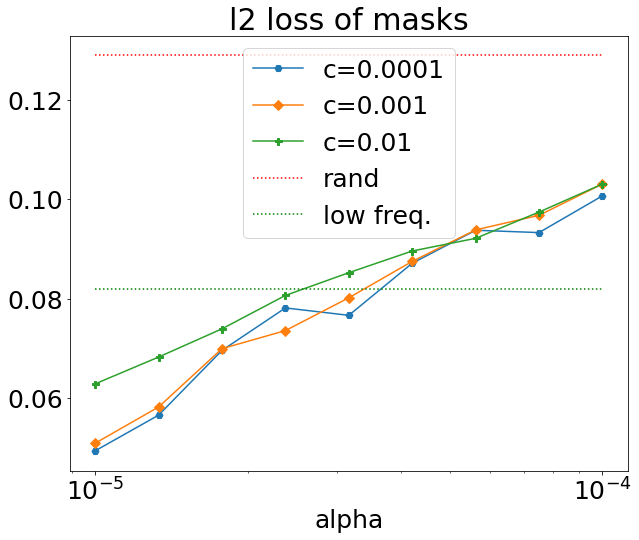

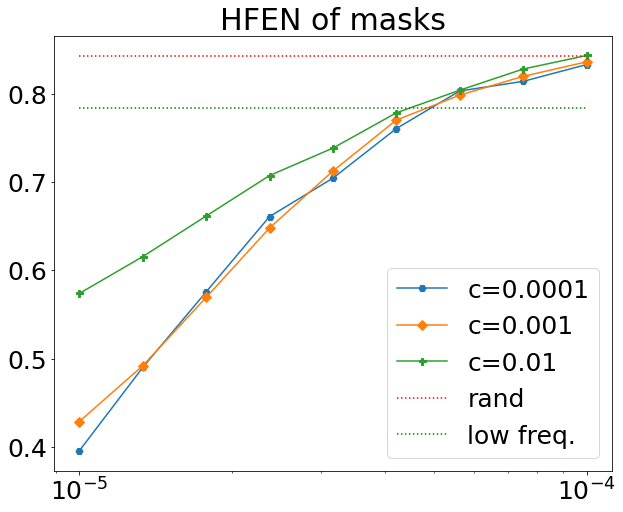

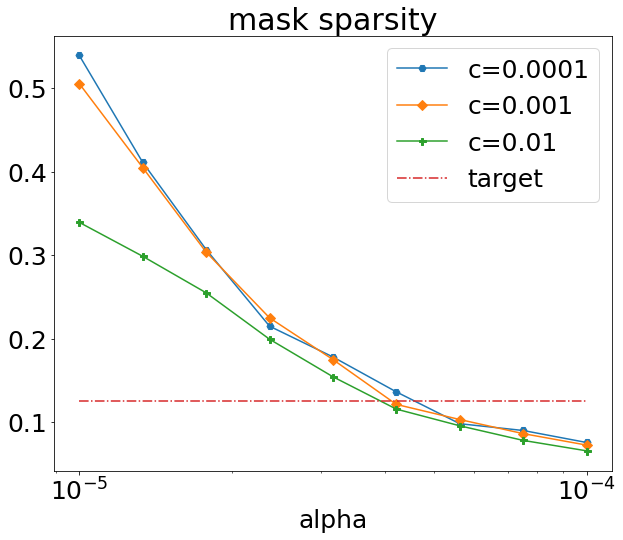

In [13]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,l2loss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,color='r',label='rand',linestyle = 'dotted')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,color='g',label='low freq.',linestyle = 'dotted')
plt.title('l2 loss of masks')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,hfen[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,color='r',label='rand',linestyle = 'dotted')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,color='g',label='low freq.',linestyle = 'dotted')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),'-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

# 4-fold check

In [ ]:
corefreq = 16
budget   = 64
from mnet import MNet
mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
mnet.apply(weights_init)
mnet.eval()
print('mnet is initialized')

In [ ]:
xstar = xfull[0:5,:,:]
for ind in range(xstar.shape[0]):
    xstar[ind,:,:] = xstar[ind,:,:]/xstar[ind,:,:].max()

NN         = 11
alpha_grid = 10**(np.linspace(-4.5,-3.5,NN))
c_grid     = np.array([1e-4,1e-3,1e-2,1e-1])

l2loss   = np.zeros((NN,5))
hfen     = np.zeros((NN,5))
sparsity = np.zeros((NN,5))

maxIter_mb = 30
lr_mb      = 1e-2

unet_skip = True

In [ ]:
highmask = mask_filter(mask_naiveRand(320,fix=corefreq,other=1.5*budget,roll=True)[0],base=corefreq,roll=True)
highmask = highmask.repeat(5,1)

c_ind = 0
for c in c_grid:
    print(f'c_ind {c_ind+1} out of {len(c_grid)}')
    a_ind = 0
    for alpha in alpha_grid:
        print(f'alpha_ind {a_ind+1} out of {len(alpha_grid)}')
        # load a unet for maskbackward
        UNET = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
        unetpath = '/home/huangz78/checkpoints/unet_1_False.pth'
        checkpoint = torch.load(unetpath)
        UNET.load_state_dict(checkpoint['model_state_dict'])
        UNET.train()
    # highmask_refined,unet = mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
    #                   beta=1.,alpha=alpha,c=c,\
    #                   maxIter=maxIter_mb,seed=0,break_limit=maxIter_mb*3//5,\
    #                   lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
    #                   verbose=True,dtyp=torch.float)
        (l2loss[a_ind,c_ind],hfen[a_ind,c_ind]),sparsity[a_ind,c_ind] =\
                        mask_backward(highmask,xstar,unet=UNET, mnet=mnet,\
                          beta=1.,alpha=alpha,c=c,\
                          maxIter=maxIter_mb,seed=0,break_limit=np.inf,\
                          lr=lr_mb,mode='UNET',budget=budget,normalize=False,\
                          dtyp=torch.float,verbose=True,testmode='sigpy',hfen=True,\
                          return_loss_only=True)
        a_ind += 1
    print('\n')
    c_ind += 1

In [ ]:
# highmask = sigmoid_binarize(raw_normalize(mnet(z),budget=budget))
randmask = torch.zeros(highmask.shape)
for ind in range(highmask.shape[0]):
    sampinds = np.random.choice(highmask.shape[1],budget,replace=False)
    randmask[ind,sampinds] = 1
lowfmask,_,_ = mask_naiveRand(xstar.shape[1]-corefreq,fix=budget,other=0,roll=True)
lowfmask = lowfmask.repeat(highmask.shape[0],1)

In [ ]:
# full_highmask = mask_complete(highmask,320)
full_randmask = mask_complete(randmask,320)
full_lowfmask = mask_complete(lowfmask,320)

(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
# (gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')

print(rand_l2)
print(lowf_l2)
# print(gred_l2)

In [ ]:
# mnet_loss = mask_eval(full_highmask,xstar,mode='UNET',UNET=UNET)
# rand_loss = mask_eval(full_randmask,xstar,mode='UNET',UNET=UNET)
# lowf_loss = mask_eval(full_lowfmask,xstar,mode='UNET',UNET=UNET)
# print('mode = UNet')
# mnet_loss = mask_eval(full_highmask,xstar,mode='sigpy')
(rand_l2,rand_hfen) = mask_eval(full_randmask,xstar,mode='sigpy',hfen=True)
(lowf_l2,lowf_hfen) = mask_eval(full_lowfmask,xstar,mode='sigpy',hfen=True)
(gred_l2,gred_hfen) = mask_eval(full_gredmask.to(torch.float),xstar,mode='sigpy',hfen=True)
print('mode = sigpy')
# print(mnet_loss)

print(rand_l2)
print(lowf_l2)
print(gred_l2)

In [ ]:
plt.figure()
plt.plot(alpha_grid,l2loss)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_l2,label='greedy')
plt.title('l2 loss of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot(alpha_grid,hfen)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,label='low freq.')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_hfen,label='greedy')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure()
plt.plot(alpha_grid,sparsity,label='actual')
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')

In [ ]:
markers = ['H', 'D', 'P', 'X','+']
plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,l2loss[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_l2,color='r',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_l2,color='g',label='low freq.')
# plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_l2,color='k',label='greedy')
plt.title('l2 loss of masks')
plt.xlabel('alpha')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,hfen[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*rand_hfen,color='r',label='rand')
plt.plot(alpha_grid,np.ones(alpha_grid.shape)*lowf_hfen,color='g',label='low freq.')
# plt.plot(alpha_grid,np.ones(alpha_grid.shape)*gred_hfen,color='k',label='greedy')
plt.title('HFEN of masks')
plt.xscale('log')
plt.legend(loc='best')

plt.figure(figsize=(10,8))
for c_ind in range(len(c_grid)):
    plt.plot(alpha_grid,sparsity[:,c_ind],label='c='+str(c_grid[c_ind]),marker=markers[c_ind],markersize=7)
plt.plot(alpha_grid,(corefreq+budget)/320*np.ones(alpha_grid.shape),'-.',label='target')
plt.title('mask sparsity')
plt.xscale('log')
plt.legend(loc='best')
plt.xlabel('alpha')

In [ ]:
np.log10(alpha_grid[-5])

In [ ]:
from sigpy.mri.app import TotalVariationRecon
xstar = imgs[0,:,:]/torch.max(torch.abs(imgs[0,:,:].flatten()))
imgHeg, imgWid = xstar.shape[0], xstar.shape[1]
mps = np.ones((1,imgHeg,imgWid))
imgind = 15

NN = 15
Lambda_grid = 10**(np.linspace(-4,-2.5,NN))
errors = np.zeros((NN))

y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'),dim=(0,1))    
z = torch.zeros(y.shape).to(y.dtype)
z[masks[imgind,:]==1,:] = y[masks[imgind,:]==1,:]  
y_tmp = z.view(-1,imgHeg,imgWid).numpy()

xstar = xstar.numpy()

ind = 0
for Lambda in Lambda_grid:    
    x_tmp = np.fft.ifftshift( np.abs(TotalVariationRecon(y_tmp, mps, Lambda, show_pbar=False).run()) )  
    errors[ind] = np.linalg.norm(x_tmp - xstar,'fro')/np.linalg.norm(xstar,'fro')
    ind += 1
    
plt.figure()
plt.plot(Lambda_grid,errors)
plt.xscale('log')
plt.show()

### tune weight initialization function

In [ ]:
def mnet_weights_init(m):
    classname = m.__class__.__name__
    print(m)
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# reload(utils)
# from utils import mnet_weights_init

In [ ]:
corefreq = 8
budget = 32

mnet = MNet(beta=1,in_channels=2,out_size=320-corefreq, imgsize=(320,320),poolk=3)
# mnet.apply(mnet_weights_init)
# mnet.eval()
mnet(torch.randn(1,2,320,320))

### old tests

In [ ]:
from mask_backward_v3 import ThresholdBinarizeMask

In [ ]:
binarize = ThresholdBinarizeMask.apply
x = torch.tensor([0.5,-0.5],requires_grad=True)

In [ ]:
y = binarize(torch.sigmoid(3*x))
ystar = torch.tensor([0.,1.])
print(y)

In [ ]:
loss = 1/2*torch.norm(y - ystar,p=2)
optimizer = optim.SGD([{'params': x}], lr=1e-2, momentum=0)
optimizer.zero_grad()
loss.backward()

In [ ]:
x.grad

In [ ]:
data_gt = np.load('/home/huangz78/data/data_gt.npz')
picind = np.random.randint(199)
xstar = data_gt['imgdata'][:,:,27]
xstar = xstar/np.max(np.abs(xstar))
# highmask = datafornn['labels'][picind,:]
plt.figure()
plt.imshow(xstar)
plt.colorbar()
plt.show()

In [ ]:
# reload(maskbackward)
# from maskbackward import mask_backward

#mode UNET:

reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

dtyp = torch.float
# unroll_block = 8; Lambda=6.1e-4; rho=1e1

# base = .05; expand = .15
# highmask = torch.zeros((round(320*(1-base))),dtype=torch.double)
# highmask[np.random.choice(round(320*(1-base)),round(320*expand),replace=False)] = 1

highmask = mask_filter(fullmask,base=round(320*0.05),roll=True)
print(highmask.shape)

In [ ]:
n_channels = 1
UNET =  UNet(n_channels=n_channels,n_classes=n_channels,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_' + str(n_channels) + '.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
UNET.eval()

In [ ]:
## quick comparison between ifft recon and unet recon
imgHeg = 320; imgWid = 320
fullmask = torch.tensor( mask_complete(highmask,imgHeg,dtyp=torch.float) )
kplot(fullmask)
print('sparsity of fullmask = ',fullmask.sum().item()/imgHeg)

In [ ]:
xstar = torch.tensor(xstar,dtype=dtyp)
DTyp = torch.cfloat if dtyp==torch.float else torch.cdouble
y = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho'))
z = torch.fft.ifftshift(torch.tensordot(torch.diag(fullmask).to(DTyp),y,dims=([1],[0])))
kplot(y,roll=False,log=True)
kplot(z,roll=True,log=True)

In [ ]:
imgHeg = 320; imgWid = 320
x_ifft = torch.abs(F.ifftn(z,dim=(0,1),norm='ortho')).to(dtyp)
x_unet = UNET(x_ifft.view(1,1,imgHeg,imgWid)).detach()

print('error of x_ifft = ', torch.norm(torch.flatten(x_ifft)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )
print('error of x_unet = ', torch.norm(torch.flatten(x_unet)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro') )

In [ ]:
from sigpy.mri.app import TotalVariationRecon
NN = 50
Lambda_grid = 10**np.linspace(-3.5,-3,NN)
errRec = np.zeros((NN))
ind = 1

mps  = np.ones((1,imgHeg,imgWid))
y_sp = np.reshape(z.numpy(),(-1,imgHeg,imgWid))
for Lambda in Lambda_grid:
# Lambda = 10**(-6.31) 
# Lambda = 10**(-3.2755) # np.log10(Lambda_grid[np.argmin(errRec)])
    print('{} out of {}'.format(ind,NN))
    x_sp = np.fft.fftshift( np.abs(TotalVariationRecon(y_sp, mps, Lambda,show_pbar=False).run()) ) 
    x_sp = torch.tensor(x_sp)
    errRec[ind-1] = torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro')
    ind += 1
#     print('error of x_sp = ', torch.norm(torch.flatten(x_sp)-torch.flatten(xstar),'fro')/torch.norm(xstar,'fro'))

plt.figure()
plt.xscale('log')
plt.plot(Lambda_grid,errRec)

In [ ]:
np.linspace(-6,-4,gridnum)[8]

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward,mask_eval

maxIter = 200
gridnum = 10
alpha_grid = 10**np.linspace(-4.6,-4.5,gridnum)
sr_rec = np.zeros((gridnum))
mloss_rec = np.zeros(gridnum)

ind = 0
for alpha in alpha_grid:
    print('[{}/{}]  alpha {}'.format(ind+1,gridnum,alpha))
    highmask_refined,refine_mloss,init_loss = mask_backward(highmask,xstar,\
                          beta=1., alpha=alpha,maxIter=maxIter,seed=0,break_limit=maxIter//2,\
                          lr=5e-4,mode='UNET',\
                          verbose=False,dtyp=dtyp)
    print('Difference between masks: \n',highmask_refined - highmask)
#     print('Refined mask is: \n',highmask_refined)
    mloss_rec[ind] = refine_mloss
    sr_rec[ind] = (torch.sum(highmask_refined).item() + 24)/320
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,mloss_rec,label='refined')
plt.scatter(alpha_grid,init_loss*np.ones(mloss_rec.shape),label='init.')
plt.title('mask loss')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

plt.figure()
plt.scatter(alpha_grid,sr_rec,label='refined')
plt.scatter(alpha_grid,0.25*np.ones(mloss_rec.shape),label='init.')
plt.title('mask sampling ratio')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

### mask binarize test

In [ ]:
from torch.autograd import Function
class ThresholdBinarizeMask(Function):
    def __init__(self):
        """
            Straight through estimator.
            The forward step binarizes the real-valued mask.
            The backward step estimate the non differentiable > operator using sigmoid with large slope (10).
        """
        super(ThresholdBinarizeMask, self).__init__()

    @staticmethod
    def forward(ctx, input):
        batch_size = len(input)
        results = [] 

        for i in range(batch_size):
            x = input[i:i+1]
            result = (x > .5).float()
            results.append(result)

        results = torch.cat(results, dim=0)
#         ctx.save_for_backward(input)
        return results  

    @staticmethod
    def backward(ctx, grad_output):
        slope = 1
#         input = ctx.saved_tensors

        # derivative of M
        current_grad = slope

        return current_grad * grad_output

In [ ]:
threshold = ThresholdBinarizeMask.apply

In [ ]:
x = torch.tensor([.1,.3,.7,.9,.6,.5,.21,.43])
x.requires_grad = True
b = threshold(x)

In [ ]:
y = torch.tensor([1., 1., 1., 1., 0., 1., 0., 1.])
loss = torch.norm((y-b),p=2)**2

In [ ]:
optimizer = optim.SGD([{'params': x}], lr=1e-2)

In [ ]:
optimizer.zero_grad()
loss.backward()
print('old x: ', x)
print('grad: ', x.grad)
optimizer.step()
print('updated x: ', x)

### arXiv

In [ ]:
reload(mask_backward_new)
from mask_backward_new import mask_backward

# mode ADMM:

highmask = torch.zeros((round(320*0.9)))
highmask[np.random.choice(round(320*0.9),int(320*.1),replace=False)] = 1

naive_mloss = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
highmask_refined,refine_mloss = mask_backward(highmask,xstar,\
                          beta=1., alpha=1e1,maxIter=200,unroll_block=unroll_block,seed=0,break_limit=100,\
                          lr=5e-4,mode='ADMM',Lambda=Lambda,rho=rho,\
                          verbose=True,perturb=False,perturb_freq=5,eps=1e-2)

In [ ]:
# vary sampling ratio, observe RMSE for the same image.
reload(mask_backward_new)
from mask_backward_new import mask_backward

base=0.1
r_grid = np.array([0.1,0.15,0.2])
naive_mloss = np.zeros((r_grid.size))
refine_mloss = np.zeros((r_grid.size))

sampRatio = np.zeros((r_grid.size))

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/3)

np.random.seed(0)

ind = 0
for r in r_grid:
    print('\n r {}, the {} item out of {}'.format(r,ind+1,r_grid.size))
    highmask = torch.zeros((round(320*(1-base))))
    highmask[np.random.choice(round(320*(1-base)),int(320*r),replace=False)] = 1
    
    naive_mloss[ind] = mask_eval(mask_complete(highmask.to(torch.double),320),xstar,unroll_block=unroll_block,Lambda=Lambda,rho=rho) * 100
    highmask_refined,refine_mloss[ind] = mask_backward(highmask,xstar,seed=0,\
                              beta=1., alpha=9.5e0,maxIter=maxIter,unroll_block=unroll_block,break_limit=break_limit,\
                              lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                              verbose=True,perturb=False,perturb_freq=5,eps=1e-2)
    sampRatio[ind] = (highmask_refined.sum().item() + round(320*0.1))/320
    ind += 1

In [ ]:
print('sampRatio: ',sampRatio)
plt.figure()
plt.scatter(r_grid,naive_mloss,label='naive')
plt.scatter(sampRatio,refine_mloss,label='refined')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

In [ ]:
## find a good alpha for l1 penalty
reload(mask_backward_new); reload(utils);
from mask_backward_new import mask_backward
alpha_grid = np.linspace(1,10,10)
sparsity_ = np.zeros(alpha_grid.size)
change_count = np.zeros(alpha_grid.size)

unroll_block = 6; Lambda=6.1e-4; rho=1e1; lr = 5e-2
maxIter = 300; break_limit = round(maxIter/2)
# add samp. ratio. = .1 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?
# add samp. ratio. = .2 ---> best alpha = ?

base = 0.05
additional = 0.125

highmask = torch.zeros((round(320*(1-base))))
highmask[np.random.choice(round(320*(1-base)),round(320*additional),replace=False)] = 1

ind = 0
for alpha in alpha_grid:
    print('\n\talpha = {}'.format(alpha))
    highmask_refined,_ = mask_backward(highmask,xstar,\
                  beta=1, alpha=alpha,maxIter=maxIter,unroll_block=unroll_block,seed=0,break_limit=break_limit,\
                  lr=lr,mode='ADMM',Lambda=Lambda,rho=rho,\
                  perturb=False,perturb_freq=10,verbose=True)
    sparsity_[ind] = mask_complete(highmask_refined.to(torch.double),320).sum().item()/320
    change_count[ind] = torch.abs(highmask_refined - highmask).sum().item()
    ind += 1

In [ ]:
plt.figure()
plt.scatter(alpha_grid,sparsity_,label='end')
plt.scatter(alpha_grid,(base+additional)*np.ones(alpha_grid.size),label='start')
plt.title('sparsity')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")

plt.figure()
plt.scatter(alpha_grid,change_count)
# plt.xscale('log')
plt.title('change count')

In [ ]:
naive_mloss = mask_eval(mask_complete(highmask,imgHeg,dtyp=dtyp),xstar,mode='UNET',UNET=UNET,dtyp=dtyp) * 100
print('naive mask loss = ',naive_mloss)

In [ ]:
### verify that UNET works fine
z = apply_mask(full_gredmask,yfull,mode='c')
xs = torch.abs(F.ifftn(F.ifftshift(z),dim=(1,2),norm='ortho'))
xs = torch.reshape(xs,(xs.shape[0],1,xs.shape[1],xs.shape[2]))

UNET.eval()
imgind = 0
xrecon = UNET(xs)
plt.figure()
plt.title('recon')
plt.imshow(xrecon.detach().numpy()[imgind,0,:,:])
plt.colorbar()
plt.show()

plt.figure()
plt.title('gt')
plt.imshow(xstar.detach().numpy()[imgind,:,:])
plt.colorbar()
plt.show()
print(torch.norm(xrecon[imgind,0,:,:]-xstar[imgind,:,:],'fro')/torch.norm(xstar[imgind,:,:],'fro').item())

In [ ]:
reload(utils)
from utils import hfen

In [ ]:
torch.squeeze(xrecon)[0,:,:].shape

In [ ]:
hfen(torch.squeeze(xrecon)[imgind,:,:],xstar[imgind,:,:],base=0)